## Same Data handling as previous

In [ ]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print("length of dataset in characters: ", len(text))

chars = sorted(list(set(text)))
vocab_size = len(chars)
print(vocab_size)

# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
import torch.nn as nn
import torch.nn.functional as F
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:] # to test for non overfitting

block_size = 8 
train_data[:block_size + 1]

x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")


torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

length of dataset in characters:  1115394
65
torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 1

## The Math of Self Attention: 
currently, in the 8 tokens, they "do not talk to each other", our goal is to couple them together

What we are going to do now as a proof of concept is to just take a simple average of all the previous tokens
    Do note that this is super lossy and results in losing basically most of the information of the previous tokens eg. the meanings in the embedding space

In [47]:
torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [49]:
# note that bow stands for bag of words, basically everything is inside
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T): 
        xprev = x[b,:t+1]
        # we should get a (t,C), now each element is a average of all the previous
        xbow[b,t] = torch.mean(xprev, 0)
        # Averaging over the 0th dimension, removing the time dimension

print(x[0])
print(xbow[0]) # this is the average of everything before

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])
tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


### We can make this more efficient using matrix multiplication

Once again, think of a matrix multiplcation as a weighted sum of the col of the second matrix by the 

to adapt it to the use case of averages, we can use a lower triangular matrix! 
    do note that the division is placed inside the lower triangular matrix, giving us the average in this example

In [50]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [ ]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T)) #is there a possibility of these weights being a learnable param?
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

### Version 3 using softmax:

this basically gets the same thing, but theres benefits
- in this case, when we set -inf, we basically say tokens cannot communicate at all
- this allows us to manipulate which tokens can communicate "more"
- Esssentially we can eventually train tokens to have more affinity to other tokens by adjusing the weight in the softmax

In [53]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)


True

## Working on Self Attention

Each token will "emmit" 2 vectors:
    Query: what the token is looking for
    key: what is the key to this token lol 

Affinities is the dot product between the keys and the queries 
    that dot product, is not `wei`!



note that the output is 16 dimensional, equal to the head_size


Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [ ]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
# As usual, we dont allow future stuff to communicate 
wei = F.softmax(wei, dim=-1) #normalize so that it sums to 1 

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

In [56]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

## Illustration of why we scale `wei`
When the variance is low, the distribution is somewhat balanced, the attention is kinda "spread"

However, with high variance, upon applying the softmax, the initialization results in something like this: `tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])`
- This implies that the attention is really only directed at one other node, this is not a great place to start training

In [58]:
print(k.var())
print(q.var())
print(torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1))
print(torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1)) # gets too peaky, converges to one-hot

tensor(1.0449)
tensor(1.0700)
tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])
tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])


# Multi Headed Attention
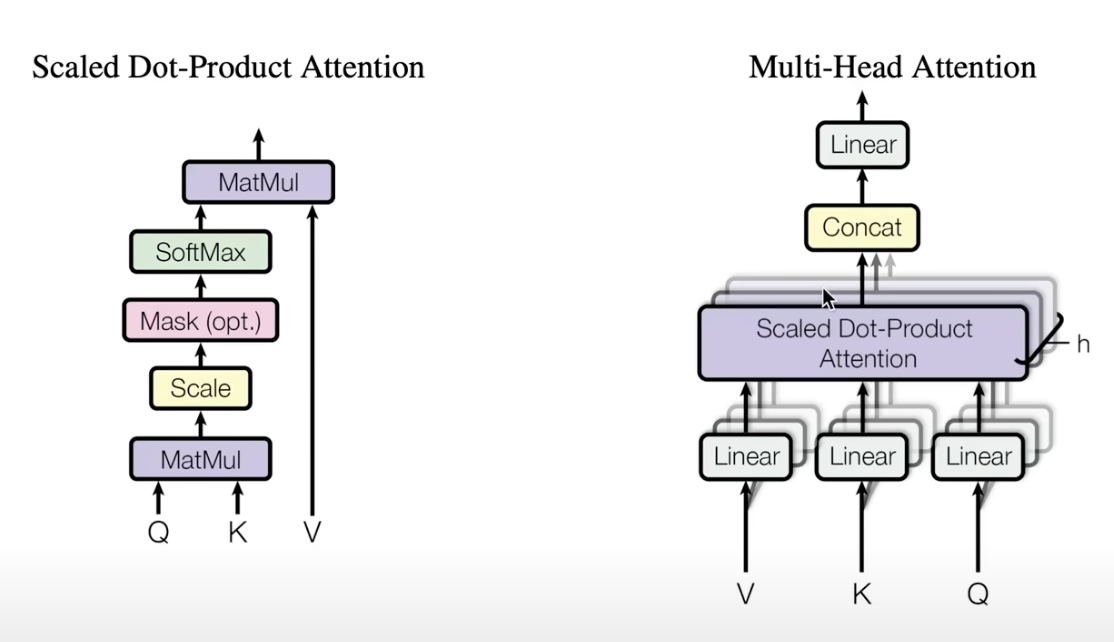
    TLDR: multiple attentions in parallel

Yes, exactly! In multi-headed attention, for each token in the input sequence, multiple queries (Q), keys (K), and values (V) are generated, one set for each head. Here’s a breakdown:

1. Multiple Q, K, V for Each Token
	•	Each attention head has its own set of learnable weight matrices for ￼, ￼, and ￼:
	•	￼, ￼, ￼ for the ￼-th head.
	•	For a given token embedding ￼, the projections are computed independently for each head:
	•	Query for head ￼: ￼
	•	Key for head ￼: ￼
	•	Value for head ￼: ￼
	•	Therefore, each token is associated with multiple Q, K, and V vectors, one set per head.

2. Why Do We Have Multiple Q, K, and V?
	•	Each head learns to focus on different aspects of the input sequence:
	•	One head might learn syntactic relationships.
	•	Another might focus on longer dependencies or semantic meanings.
	•	The multiple Q, K, V vectors allow each head to compute its own unique self-attention scores, capturing diverse patterns in the data.

3. How It Works in Practice
	•	For a single token ￼, if you have ￼ attention heads:
	•	The ￼ embedding is transformed into ￼ Q vectors, ￼ K vectors, and ￼ V vectors.
	•	The self-attention computation for each head is independent:
	•	Attention weights: ￼
	•	Output: ￼
	•	These outputs from all heads are then concatenated and projected back into the model’s embedding space.

4. Example from Code

In your provided code:

self.key = nn.Linear(n_embd, head_size, bias=False)
self.query = nn.Linear(n_embd, head_size, bias=False)
self.value = nn.Linear(n_embd, head_size, bias=False)

Each attention head has separate key, query, and value projections (linear layers), meaning for a single token, it generates different Q, K, and V vectors for each head.

In the multi-head implementation:

self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

The model creates multiple Head instances, each managing its own Q, K, V computation.

5. Final Thought

The multiple Q, K, and V vectors (one set per head) are the cornerstone of the diversity and representational power of multi-headed attention, enabling the model to simultaneously capture a variety of relationships and patterns in the data.

# This is the final form of our model
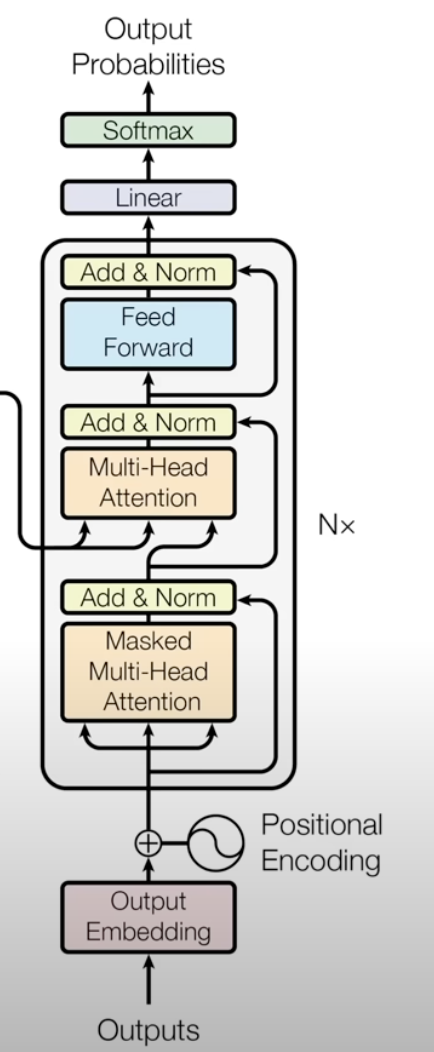
we still have to add risidual connections
We have also yet to add layer normalization


# layer normm

In [60]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [61]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [62]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-3.5763e-09), tensor(1.0000))